In [ ]:
#import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from collections import Counter

In [ ]:
#general configuration
IMG_SIZE = (224, 224)
NUM_CLASSES = 3

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#paths to the dataset
train_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_Input.zip"
test_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_Input.zip"
valid_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_Input.zip"
train_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_GroundTruth.csv"
test_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_GroundTruth.csv"
valid_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_GroundTruth.csv"
train_dir = "/content/ISIC2018_Task3_Training_Input"
test_dir = "/content/ISIC2018_Task3_Test_Input"
valid_dir = "/content/ISIC2018_Task3_Validation_Input"

In [ ]:
#................Utility Functions......................

def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)
    df['new_image_id'] = df['image'] + ".jpg"

    #create label column from diagnosis columns
    diagnosis_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

    #find the index (i.e., label) where the value is 1
    df['label'] = df[diagnosis_cols].idxmax(axis=1)

    #map string labels to integers
    label_mapping = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
    df['label'] = df['label'].map(label_mapping)

    return df

def show_class_distribution(y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)

    class_labels = [
        'Melanoma (0)',         # MEL
        'Nevus (1)',            # NV
        'Basal Cell Carcinoma (2)',  # BCC
        'Actinic Keratosis (3)',     # AKIEC
        'Benign Keratosis (4)',      # BKL
        'Dermatofibroma (5)',        # DF
        'Vascular Lesion (6)'        # VASC
    ]

    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        class_name = class_labels[label] if label < len(class_labels) else f"Unknown Class ({label})"
        print(f"  Class {label} ({class_name}): {count} samples")

def show_stratified_sample_images(df, image_dir, samples_per_class=2):
    label_map = {
        0: 'Melanoma',
        1: 'Nevus',
        2: 'BCC',
        3: 'AKIEC',
        4: 'BKL',
        5: 'DF',
        6: 'VASC'
    }

    sample_df = df.groupby('label').apply(lambda x: x.sample(min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)
    num_samples = len(sample_df)
    cols = min(6, num_samples)
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(3 * cols, 3 * rows))

    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(image_dir, row.new_image_id)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        label_name = label_map.get(row.label, "Unknown")
        plt.imshow(img)
        plt.title(f"{label_name}\n({row.label})", fontsize=9)
        plt.axis('off')

    plt.suptitle("Stratified Sample Images", fontsize=14)
    plt.tight_layout()
    plt.show()

def analyze_image_sizes(image_dir):
    sizes = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                sizes.append((img.shape[1], img.shape[0]))  # (width, height)

    size_counts = Counter(sizes)
    print(f"Total images analyzed = {len(sizes)}")
    print("Most common image sizes include:")
    for size, count in size_counts.most_common(10):
        print(f"{size}: {count} images")
#check that all image-label pairs are accounted for
def check_metadata_consistency(df, image_dir):
    image_files = {f for f in os.listdir(image_dir) if f.endswith(".jpg")}
    label_files = set(df['new_image_id'])
    missing_in_dir = label_files - image_files
    missing_in_csv = image_files - label_files
    print(f"Images in CSV but missing in dir: {len(missing_in_dir)}")
    print(f"Images in dir but missing in CSV: {len(missing_in_csv)}")

#empirical blur threshold using Laplacian variance
def detect_blurry_images(image_dir, threshold=70.0):
    blurry_count = 0
    total_checked = 0

    for img_name in os.listdir(image_dir):
        #only process .jpg files, skip any with '_superpixels' in name
        if not img_name.endswith(".jpg"):
            continue
        if "_superpixels" in img_name:
            continue

        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            total_checked += 1
            lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
            if lap_var < threshold:
                blurry_count += 1

    print(f"Checked {total_checked} valid images.")
    print(f"Blurry images (variance < {threshold}): {blurry_count}")

def plot_intensity_histogram(image_dir, sample_size=50):
    pixel_values = []

    valid_images = [f for f in os.listdir(image_dir)
                    if f.endswith(".jpg") and "_superpixels" not in f]

    sampled_images = valid_images[:sample_size]  # or random.sample

    for img_name in sampled_images:
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            #only get a random subset of pixels to save memory
            flat = img.flatten()
            if len(flat) > 50000:
                flat = np.random.choice(flat, 50000, replace=False)
            pixel_values.append(flat)

    #concatenate all arrays efficiently
    all_pixels = np.concatenate(pixel_values)

    #plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(all_pixels, bins=50, color='gray')
    plt.title("Grayscale Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
#extract and load data
extract_zip(train_zip)
extract_zip(test_zip)
extract_zip(valid_zip)
train_df = load_and_process_labels(train_csv)
test_df = load_and_process_labels(test_csv)
valid_df = load_and_process_labels(valid_csv)

In [ ]:
#class distribution
show_class_distribution(train_df['label'].values, title="Class Distribution - Training Data")
print("Total number of training images:", len(train_df), "\n")

show_class_distribution(test_df['label'].values, title="Class Distribution - Testing Data")
print('Total number of testing images:', len(test_df), "\n")

show_class_distribution(valid_df['label'].values, title="Class Distribution - Validation Data")
print('Total number of validation images:', len(valid_df), "\n")




Class Distribution - Training Data:
  Class 0 (Melanoma (0)): 1113 samples
  Class 1 (Nevus (1)): 6705 samples
  Class 2 (Basal Cell Carcinoma (2)): 514 samples
  Class 3 (Actinic Keratosis (3)): 327 samples
  Class 4 (Benign Keratosis (4)): 1099 samples
  Class 5 (Dermatofibroma (5)): 115 samples
  Class 6 (Vascular Lesion (6)): 142 samples
Total number of training images: 10015 


Class Distribution - Testing Data:
  Class 0 (Melanoma (0)): 171 samples
  Class 1 (Nevus (1)): 909 samples
  Class 2 (Basal Cell Carcinoma (2)): 93 samples
  Class 3 (Actinic Keratosis (3)): 43 samples
  Class 4 (Benign Keratosis (4)): 217 samples
  Class 5 (Dermatofibroma (5)): 44 samples
  Class 6 (Vascular Lesion (6)): 35 samples
Total number of testing images: 1512 


Class Distribution - Validation Data:
  Class 0 (Melanoma (0)): 21 samples
  Class 1 (Nevus (1)): 123 samples
  Class 2 (Basal Cell Carcinoma (2)): 15 samples
  Class 3 (Actinic Keratosis (3)): 8 samples
  Class 4 (Benign Keratosis (4)):

/tmp/ipython-input-23-2031050461.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('label').apply(lambda x: x.sample(min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)


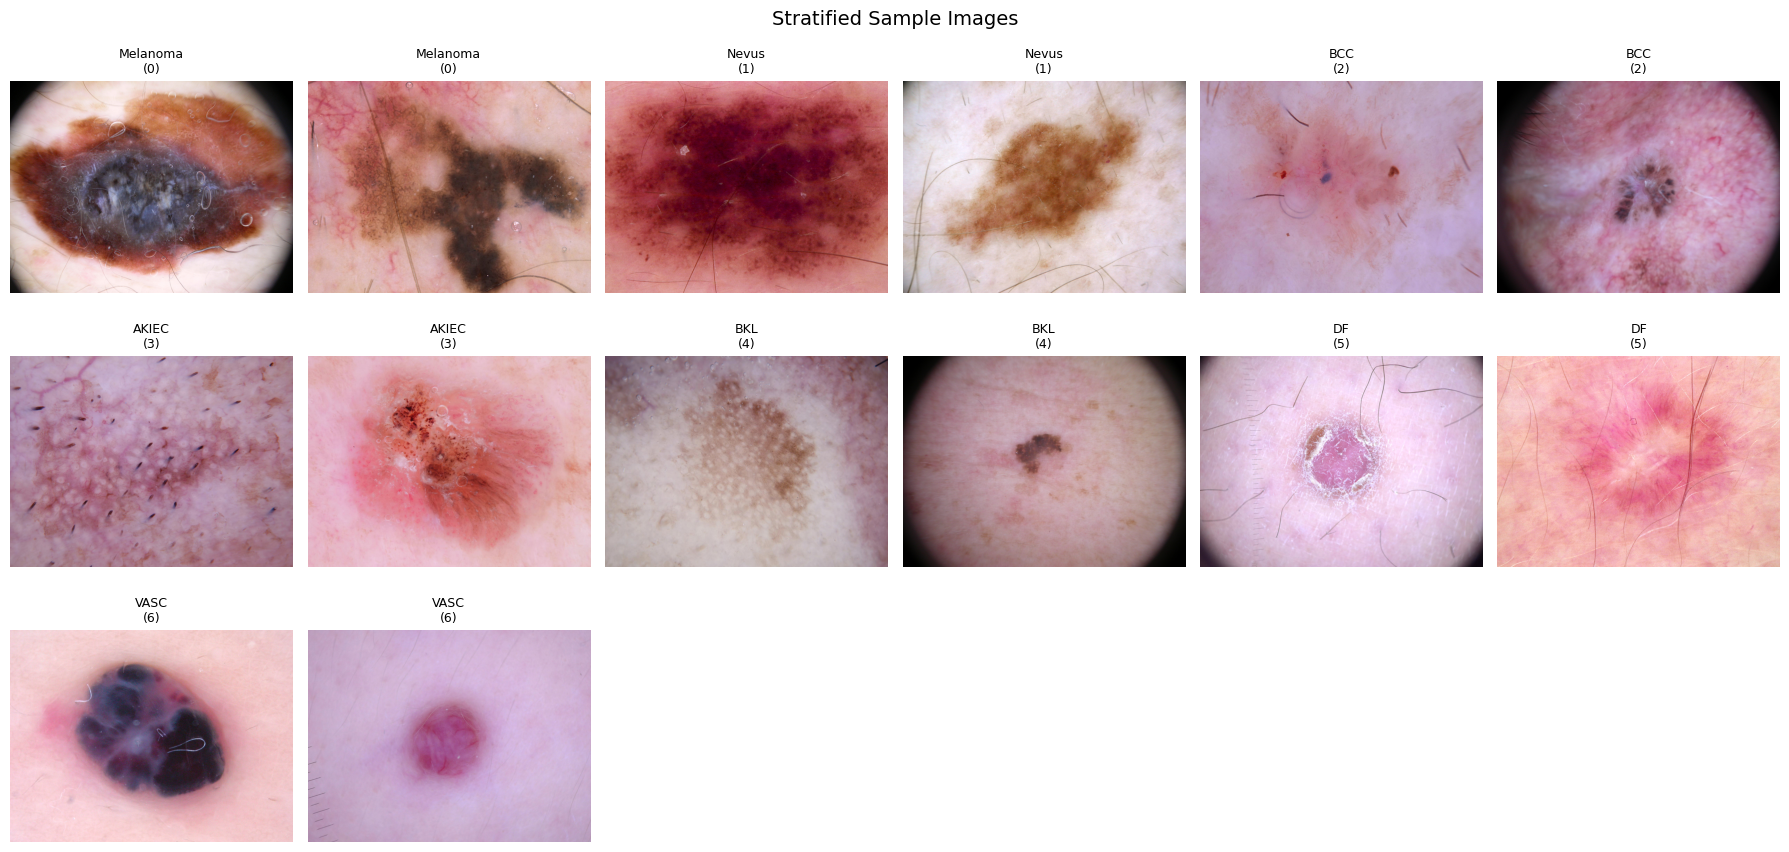

In [ ]:
#show sample training images
show_stratified_sample_images(train_df, train_dir, samples_per_class=2)

In [ ]:
#image and dimension analysis
print("\nImage Size Distribution - Training Set")
analyze_image_sizes(train_dir)

print("\nImage Size Distribution - Test Set")
analyze_image_sizes(test_dir)

print("\nImage Size Distribution - Validation Set")
analyze_image_sizes(valid_dir)


Image Size Distribution - Training Set
Total images analyzed = 10015
Most common image sizes include:
(600, 450): 10015 images

Image Size Distribution - Test Set
Total images analyzed = 1512
Most common image sizes include:
(600, 450): 1512 images

Image Size Distribution - Validation Set
Total images analyzed = 193
Most common image sizes include:
(600, 450): 193 images


In [ ]:
#metadata consistency
print("\nMetadata Consistency Check")
print("\nTraining data")
check_metadata_consistency(train_df, train_dir)

print("\nTesting data")
check_metadata_consistency(test_df, test_dir)

print("\nValidation data")
check_metadata_consistency(valid_df, valid_dir)


Metadata Consistency Check

Training data
Images in CSV but missing in dir: 0
Images in dir but missing in CSV: 0

Testing data
Images in CSV but missing in dir: 0
Images in dir but missing in CSV: 0

Validation data
Images in CSV but missing in dir: 0
Images in dir but missing in CSV: 0


In [ ]:
#blurry image detection
print("\nBlurry Image Check - Training Data")
detect_blurry_images(train_dir)

print("\nBlurry Image Check - Testing Data")
detect_blurry_images(test_dir)

print("\nBlurry Image Check - Validation Data")
detect_blurry_images(valid_dir)


Blurry Image Check - Training Data
Checked 10015 valid images.
Blurry images (variance < 70.0): 6616

Blurry Image Check - Testing Data
Checked 1512 valid images.
Blurry images (variance < 70.0): 880

Blurry Image Check - Validation Data
Checked 193 valid images.
Blurry images (variance < 70.0): 133



Grayscale Intensity Histogram - Training Data


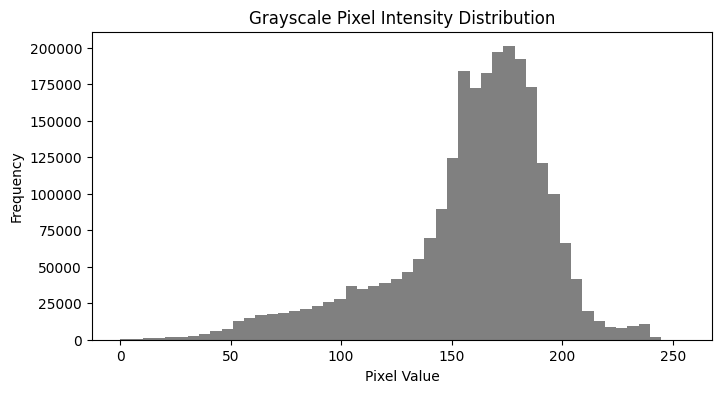


Grayscale Intensity Histogram - Testing Data


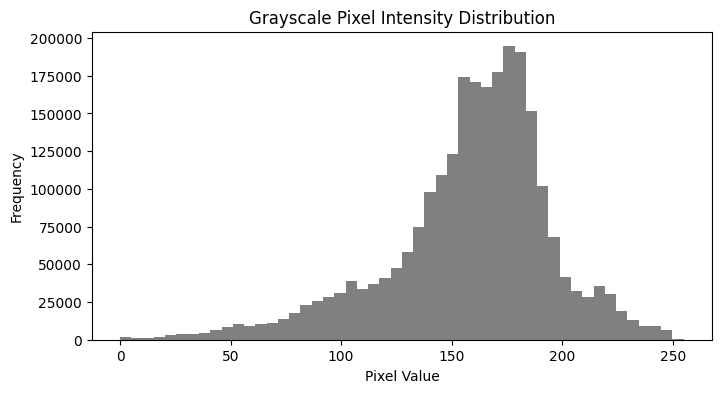


Grayscale Intensity Histogram - Validation Data


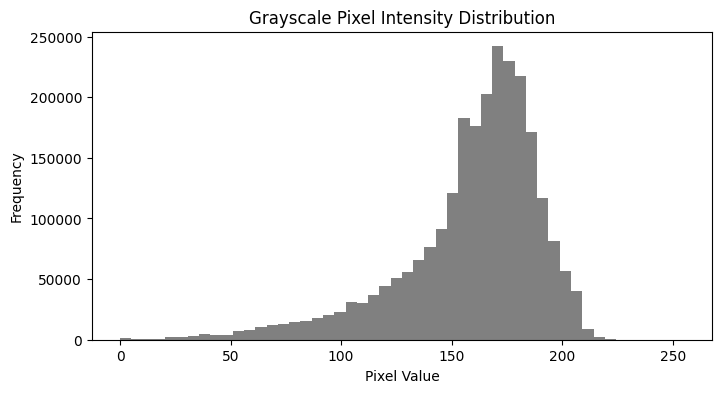

In [ ]:
#pixel intensity distribution
print("\nGrayscale Intensity Histogram - Training Data")
plot_intensity_histogram(train_dir)

print("\nGrayscale Intensity Histogram - Testing Data")
plot_intensity_histogram(test_dir)


print("\nGrayscale Intensity Histogram - Validation Data")
plot_intensity_histogram(valid_dir)